# Evaluate Scheduling Policy
Our application is designed to allow users to adjust how judiciously they use machine learning or simulation resources.
For example, one can only run simulations after the machine learning workers finish picking the next simulations to make optimal use of simulation resources.
Here, we assess the effect of the policy changes on using different resources.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load the Runs
We have a folder "policy_runs" that contains the studies of different runs

In [2]:
runs = [x for x in Path('./policy-runs/').iterdir() if x.is_dir() and not x.name.startswith('.')]
print(f'Found {len(runs)} runs')

Found 7 runs


## Compute time(s) to solution
We are going to mark finding 150 molecules with an IP above 14 as "success."
These scripts measure how many compute hours were spent to get there.

In [3]:
def measure_solution_cost(path: Path, n_target: int = 175) -> dict:
    """Measure the time elapsed and the time spent to achieve a solution to the problem
    
    Args:
        path: Path to a run
    Returns:
        Dictionary of outputs:
            - `name`: Name of the run
            - `group`: General policy of the run
            - `walltime`: Walltime until the number of target molecules was found (hr)
            - `cpu_time`: Amount of CPU node time used (node-hr)
            - `gpu_time`: Amount of GPU time used (hr)
    """
    
    # Load in the run summary
    sim_results = pd.read_csv(path / 'processed-results' / 'all-tasks.csv').query('task_type=="simulation"')
    sim_results.sort_values('time_result_received', inplace=True)
    
    # Find the time when we find enough of the target molecules
    sim_results['task_info'] = sim_results['task_info'].apply(eval)
    sim_results['ip'] = sim_results['task_info'].map(lambda x: x.get('ip', {}).get('xtb-vacuum', None))
    sim_results['num_found'] = (sim_results['ip'] > 14).cumsum()
    assert max(sim_results['num_found']) >= n_target, f'Only found {sim_results["num_found"].max()} for {path.name}'
    solution_time = min(sim_results[sim_results['num_found'] >= n_target]['time_result_received'])
                               
    # Get the row corresponding to the time where we "solved" the problem
    solution_row = sim_results.query(f'num_found == {n_target}').iloc[0]
    
    # Determine the walltime elapsed
    elapsed = solution_row['walltime'] / 3600
    
    # Get the CPU time used (node-hrs)
    # TODO (wardlt): Include tail-down in the costs
    cpu_usage = solution_row['theta_usage']
    
    # Get the GPU time used (hrs)
    gpu_usage = solution_row['lambda_usage']
    
    return {
        'walltime': elapsed,
        'cpu_time': cpu_usage,
        'gpu_time': gpu_usage
    }

In [4]:
def evaluate_policy(path: Path, n_target: int = 175) -> dict:
    """Measure the time elapsed and the time spent to achieve a solution to the problem over several runs
    
    Args:
        path: Path to a run
    Returns:
        Dictionary of outputs:
            - `name`: Name of the run
            - `group`: General policy of the run
            - `level`: Level of the tuning parameter for that policy
            - `repeats`: Number of time the test was repeated
            - `walltime`: Walltime until the number of target molecules was found (hr)
            - `cpu_time`: Amount of CPU node time used (node-hr)
            - `gpu_time`: Amount of GPU time used (hr)
    """
    
    # Get the duplicate runs
    with (path / 'duplicates.json').open() as fp:
        duplicates = json.load(fp)
        
    # Process them
    results = []
    for r in duplicates:
        try:
            results.append(measure_solution_cost(Path(r), n_target))
        except Exception as e:
            print(e)
            continue
                
    
    # Start with some basic run information
    output = {
        'name': path.name,
        'group': path.name.split("-")[0],
        'level': int(path.name.split("-")[1]) if '-' in path.name else None,
        'repeats': len(results)
     }
    
    # Add in the average of the per-run results
    if len(results) > 0:
        for k in results[0].keys():
            output[k] = np.mean([r[k] for r in results])
    return output

Compute them for all of the runs

In [5]:
usage = pd.DataFrame(evaluate_policy(x, 175) for x in runs)

Only found 112 for xtb-N8-n1-9fc88d-20May22-144718


In [6]:
usage.sort_values(['group', 'level'])

,name,group,level,repeats,walltime,cpu_time,gpu_time
0,batch_retrain-32,batch_retrain,32.0,1,3.279137,7.580144,13.753767
6,batch_retrain-64,batch_retrain,64.0,1,2.494423,8.708751,8.254744
1,continuous,continuous,NaN,4,1.660128,11.026363,10.459307
2,delay_retrain-32,delay_retrain,32.0,3,1.606457,10.573283,7.551427
3,delay_retrain-64,delay_retrain,64.0,1,1.806172,11.252739,8.598245
4,interleaved-32,interleaved,32.0,1,2.576173,7.720196,13.121575
5,interleaved-64,interleaved,64.0,1,1.761851,11.151422,10.296768


Get the improvements over "continuous" in terms of each resource

In [7]:
continuous = usage.query('name=="continuous"').iloc[0]

In [8]:
best_gpu = usage.loc[usage['gpu_time'].argmin()]
print(f'Best GPU usage is {continuous["gpu_time"] / best_gpu["gpu_time"]:.1f}x lower')

Best GPU usage is 1.4x lower


In [9]:
best_cpu = usage.loc[usage['cpu_time'].argmin()]
print(f'Best CPU usage is {continuous["cpu_time"] / best_cpu["cpu_time"]:.1f}x lower')

Best CPU usage is 1.5x lower


See how much continuous is in terms of walltime

In [10]:
worst_time = usage.loc[usage['walltime'].argmax()]
print(f'Slowest search is {worst_time["walltime"] / continuous["walltime"]:.1f}x longer')

Slowest search is 2.0x longer


## Create a Pareto plot
We are interested in two different tradeoffs: CPU vs GPU time, and CPU time vs walltime elapsed

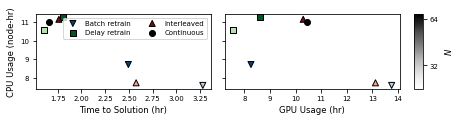

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 1.7), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# Define the style
cmaps = {
    'batch_retrain': 'Blues',
    'interleaved': 'Reds',
    'delay_retrain': 'Greens',
}
marker = {
    'batch_retrain': 'v',
    'interleaved': '^',
    'delay_retrain': 's',
}

vmin_ = np.log2(usage['level'].min()) - 0.5
vmax_ = np.log2(usage['level'].max()) + 0.1
for gid, group in usage.query('group!="continuous"').sort_values('level', ascending=False).groupby('group'):
    group_name = gid.replace("_", " ").capitalize()
    
    # Define the style
    kwargs = dict(c=np.log2(group['level']), label=group_name, vmin=vmin_, vmax=vmax_, edgecolor='k')
    kwargs['cmap'] = cmaps[gid]
    kwargs['marker'] = marker[gid]
    
    # Plot the difference metrics
    axs[0].scatter(group['walltime'], group['cpu_time'], **kwargs)
    axs[1].scatter(group['gpu_time'], group['cpu_time'], **kwargs)
    
# Remove tick labels from the second plot
axs[1].set_yticklabels([])
    
# Make a colobar
c = axs[0].scatter([], [], c=[], cmap='Greys', vmin=vmin_, vmax=vmax_)
ticks = np.arange(int(vmin_), int(vmax_) + 1)
cb = fig.colorbar(c, cax=axs[-1])
cb.set_ticks(ticks)
cb.set_ticklabels([str(i) for i in 2 ** ticks])
axs[-1].set_ylabel('$N$')

group = usage.query('group=="continuous"')
axs[0].scatter(group['walltime'], group['cpu_time'], label='Continuous', color='k', marker='o')
axs[1].scatter(group['gpu_time'], group['cpu_time'], label='Continuous', color='k', marker='o')
    
axs[0].legend(ncol=2, fontsize=7)
axs[0].set_xlabel('Time to Solution (hr)')
axs[0].set_ylabel('CPU Usage (node-hr)')
axs[1].set_xlabel('GPU Usage (hr)')

fig.tight_layout()
fig.savefig('figures/policy-comparison_pareto-plot.png', dpi=320)
fig.savefig('figures/policy-comparison_pareto-plot.pdf')

A bunch of things pop out:
- You cannot get much better than continuous retraining in terms of time-to-solution. 
- Stopping simulations during model trainin is key if you're going to conserve CPU resources
- Delaying retraining and continuing to run simulations is does save GPU resources, but not much else.